In [1]:
pip install torchinfo

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import nltk
import keras  # only for loading the dataset and preprocessing
import keras_preprocessing
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader, random_split
from gensim.models import word2vec, KeyedVectors
from sklearn.model_selection import train_test_split
import gensim.downloader
import re
from nltk.corpus import stopwords
import time
from torchinfo import summary
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [3]:
# connect to google drive
import os
from google.colab import drive
drive.mount('/content/drive')

path = "/content/drive/MyDrive/SIT coursework/667 Homeworks/Final Project"

os.chdir(path)
os.listdir(path)

Mounted at /content/drive


['data',
 'regulationword2vec_mincount1-300.model',
 'output',
 'pretrained_data_for_CNN_LSTM.csv',
 'pretrained_test_data_for_CNN_LSTM.csv',
 'TFIDF_Sklearn_SVC_NB_LR.ipynb',
 'Pretrained_Bert_Pytrochlightning.ipynb',
 'answer_w2vcnnlstm.csv',
 'Copy of BOW_NAIVE_BASELINE_model.ipynb',
 'BOW_NAIVE_BASELINE_model.ipynb',
 'Baseline-CNN-CNN+LSTM.ipynb',
 'CNN.ipynb',
 '(pretrained-custom)Embedding+CNN.ipynb']

In [4]:
df = pd.read_csv('./data/train_final.csv')
df.drop('Unnamed: 0', axis =1, inplace = True)
df['context'] = df['name'] + '. ' + df['document_text']

test_df = pd.read_csv('./data/test.csv')
test_df['context'] = test_df['name'] + '. ' + test_df['document_text']

In [5]:
# generate target columns
label_cols = [col for col in df.columns if col not in ['id', 'name', 'document_text', 'context']]
label_cols

['Accounting and Finance',
 'Antitrust',
 'Banking',
 'Broker Dealer',
 'Commodities Trading',
 'Compliance Management',
 'Consumer protection',
 'Contract Provisions',
 'Corporate Communications',
 'Corporate Governance',
 'Definitions',
 'Delivery',
 'Examinations',
 'Exemptions',
 'Fees and Charges',
 'Financial Accounting',
 'Financial Crime',
 'Forms',
 'Fraud',
 'IT Risk',
 'Information Filing',
 'Insurance',
 'Legal',
 'Legal Proceedings',
 'Licensing',
 'Licensure and certification',
 'Liquidity Risk',
 'Listing',
 'Market Abuse',
 'Market Risk',
 'Monetary and Economic Policy',
 'Money Services',
 'Money-Laundering and Terrorist Financing',
 'Natural Disasters',
 'Payments and Settlements',
 'Powers and Duties',
 'Quotation',
 'Records Maintenance',
 'Regulatory Actions',
 'Regulatory Reporting',
 'Required Disclosures',
 'Research',
 'Risk Management',
 'Securities Clearing',
 'Securities Issuing',
 'Securities Management',
 'Securities Sales',
 'Securities Settlement',
 'Tra

(array([2959., 1195.,  456.,  215.,   80.,   49.,   22.,   11.,    3.,
           3.]),
 array([  59. ,  181.6,  304.2,  426.8,  549.4,  672. ,  794.6,  917.2,
        1039.8, 1162.4, 1285. ]),
 <a list of 10 Patch objects>)

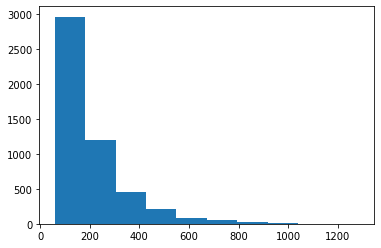

In [6]:
# find out the distribution of context lengths
from collections import Counter
import matplotlib.pyplot as plt
def bag_of_words(text):
    # TODO: Implement bag of words
    return len(text.split(' '))
plt.hist(test_df['context'].apply(bag_of_words))

In [7]:
#define preprocessing code for further use

def clean_text(text):
    if text == None:
        return None
    text = text.lower()
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "can not ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r"\'scuse", " excuse ", text)
    text = re.sub('\W', ' ', text)
    text = re.sub('\s+', ' ', text)
    text = re.sub('\d+', ' ', text)
    text = re.sub('_+', ' ', text)
    text = re.sub(' +', ' ', text)
    text = text.strip(' ')
    
    return text

def tokenizer(text):
    sentences = nltk.sent_tokenize(text)

    sentences = [nltk.word_tokenize(sentence) for sentence in sentences]

    for i in range(len(sentences)):
        sentences[i] = [word for word in sentences[i] if word not in stopwords.words('english')]
    
    return sentences[0]

In [8]:
df['context'] = df['context'].map(lambda con: tokenizer(clean_text(con)))
test_df['context'] = test_df['context'].map(lambda con: tokenizer(clean_text(con)))

In [9]:
my_word2vec_pretrained = gensim.downloader.load('glove-wiki-gigaword-100')

[==================================================] 100.0% 128.1/128.1MB downloaded


In [ ]:
my_word2vec_pretrained.wv.vocab.keys()

In [12]:
my_word2vec_custom = word2vec.Word2Vec.load('regulationword2vec_mincount1-300.model')

In [11]:
pretrained_weights = torch.FloatTensor(my_word2vec_pretrained.wv.vectors)
df['pretrained'] = df['context'].map(lambda li: pd.Series(li).map(lambda word: my_word2vec_pretrained.wv.index2word.index(word) if word in my_word2vec_pretrained.wv.vocab.keys() else np.NaN))
test_df['pretrained'] = test_df['context'].map(lambda li: pd.Series(li).map(lambda word: my_word2vec_pretrained.wv.index2word.index(word) if word in my_word2vec_pretrained.wv.vocab.keys() else np.NaN))

<ipython-input-11-3c6c53617c4b>:1: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  pretrained_weights = torch.FloatTensor(my_word2vec_pretrained.wv.vectors)
<ipython-input-11-3c6c53617c4b>:2: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  df['pretrained'] = df['context'].map(lambda li: pd.Series(li).map(lambda word: my_word2vec_pretrained.wv.index2word.index(word) if word in my_word2vec_pretrained.wv.vocab.keys() else np.NaN))
<ipython-input-11-3c6c53617c4b>:3: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  test_df['pretrained'] = test_df['context'].map(lambda li: pd.Series(li).map(lambda word: my_word2vec_pretrained.wv.index2word.index(word) if word in my_word2vec_pretrained.wv.vocab.keys() else np.NaN))


In [13]:
df['pretrained'].map(lambda i: i.dropna(inplace=True))
test_df['pretrained'].map(lambda i: i.dropna(inplace=True))

0       None
1       None
2       None
3       None
4       None
        ... 
4988    None
4989    None
4990    None
4991    None
4992    None
Name: pretrained, Length: 4993, dtype: object

In [15]:
custom_weights = torch.FloatTensor(my_word2vec_custom.wv.vectors)

In [14]:
df['custom_pretrained'] = df['context'].map(lambda li: pd.Series(li).map(lambda word: my_word2vec_custom.wv.index2word.index(word)))
test_df['custom_pretrained'] = test_df['context'].map(lambda li: pd.Series(li).map(lambda word: my_word2vec_custom.wv.index2word.index(word)))

In [16]:
train_df, eval_df = train_test_split(df, train_size = 0.8,test_size = 0.2, random_state=42)

In [17]:
DOC_LEN = 384
train_x = keras.utils.pad_sequences(train_df['pretrained'],
                                    value=0,
                                    padding='post',
                                    maxlen=DOC_LEN)

eval_x = keras.utils.pad_sequences(eval_df['pretrained'],
                                    value=0,
                                    padding='post',
                                    maxlen=DOC_LEN)

test_x = keras.utils.pad_sequences(test_df['pretrained'],
                                    value=0,
                                    padding='post',
                                    maxlen=DOC_LEN)

print(train_x.shape)
print(eval_x.shape)
print(test_x.shape)

(7887, 384)
(1972, 384)
(4993, 384)


In [18]:
DOC_LEN = 384
cus_train_x = keras.utils.pad_sequences(train_df['custom_pretrained'],
                                    value=0,
                                    padding='post',
                                    maxlen=DOC_LEN)

cus_eval_x = keras.utils.pad_sequences(eval_df['custom_pretrained'],
                                    value=0,
                                    padding='post',
                                    maxlen=DOC_LEN)

cus_test_x = keras.utils.pad_sequences(test_df['custom_pretrained'],
                                    value=0,
                                    padding='post',
                                    maxlen=DOC_LEN)

print(cus_train_x.shape)
print(cus_eval_x.shape)
print(cus_test_x.shape)

(7887, 384)
(1972, 384)
(4993, 384)


In [20]:
class RegulationDataset(Dataset):
    def __init__(self, features, dataframe):
        self.dataframe = dataframe
        self.features = torch.IntTensor(features)

    def __len__(self):
        return len(self.dataframe)
      
    def __getitem__(self, index):        
        data_row = self.dataframe.iloc[index]

        labels = data_row[label_cols]

        return self.features[index], torch.FloatTensor(labels)

class RegulationTestDataset(Dataset):
    def __init__(self, features):
        self.features = torch.IntTensor(features)

    def __len__(self):
        return len(self.features)
      
    def __getitem__(self, index):        
        return self.features[index]

# datasets
train_dataset = RegulationDataset(train_x, train_df)

eval_dataset = RegulationDataset(eval_x, eval_df)

test_dataset = RegulationTestDataset(test_x)

cus_train_dataset = RegulationDataset(cus_train_x, train_df)

cus_eval_dataset = RegulationDataset(cus_eval_x, eval_df)

cus_test_dataset = RegulationTestDataset(cus_test_x)

In [21]:
class TextCNN(nn.Module):
    def __init__(self, weights, embedding_dim, out_channels, dropout_ratio):
        super(TextCNN, self).__init__()
        self.weights = weights
        self.embedding_dim = embedding_dim
        self.dropout_ratio = dropout_ratio
        
        # embedding
        self.embedding = nn.Embedding.from_pretrained(self.weights)  # (-1, DOC_LEN, embedding_dim), num_embedding: embedding dict size, embedding_dim: length of embedding vector
        
        # 1D CNN
        # unigram
        self.unigram = nn.Sequential(# input (-1, embedding_dim, DOC_LEN)
        nn.Conv1d(in_channels=embedding_dim, out_channels=out_channels, kernel_size=2),  # (-1, 64, DOC_LEN)
        nn.ReLU(),
        nn.MaxPool1d(kernel_size=DOC_LEN - 2 + 1),  # (-1, 64, 1)
        nn.Flatten()  # (-1, 64 * 1)
        )
        # bigram
        self.bigram = nn.Sequential(# input (-1, embedding_dim, DOC_LEN)
        nn.Conv1d(in_channels=embedding_dim, out_channels=out_channels, kernel_size=3),  # (-1, 64, DOC_LEN-2+1) ??? why DOC_LEN - 2 + 1
        nn.ReLU(),
        nn.MaxPool1d(kernel_size=DOC_LEN - 3 + 1),  # (-1, 64, 1)
        nn.Flatten()  # (-1, 64 * 1)
        )
        # trigram
        self.trigram = nn.Sequential(# input (-1, embedding_dim, DOC_LEN)
        nn.Conv1d(in_channels=embedding_dim, out_channels=out_channels, kernel_size=4),  # (-1, 64, DOC_LEN-3+1)
        nn.ReLU(),
        nn.MaxPool1d(kernel_size=DOC_LEN - 4 + 1),  # (-1, 16, 7)
        nn.Flatten()  # (-1, 64 * 1)
        )
        # simple classifier
        self.classifier = nn.Sequential(
            nn.Dropout(dropout_ratio),
            nn.Linear(in_features=out_channels*3, out_features=50)
        )
    def forward(self, x):
        # get embedding
        x = self.embedding(x)
        # make sure we are convolving on each word
        x = torch.transpose(x, dim0=1, dim1=2)  # (-1, DOC_LEN, embedding_dim): embedding on 1(DOC_LEN) & 2(embedding_dim) dims
        # 1d cnn output
        uni_gram_output = self.unigram(x)
        bi_gram_output = self.bigram(x)
        tri_gram_output = self.trigram(x)

        # concatenate
        x = torch.cat((uni_gram_output, bi_gram_output, tri_gram_output), dim=1)
        # classifier
        x = self.classifier(x)

        return x

In [22]:
def train_model(model, train_dataset, test_dataset, device, lr=0.0001, epochs=20, batch_size=32):
    # construct dataloader
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

    # move model to device
    model = model.to(device)

    # history
    history = {'train_loss': [],
               'train_acc': [],
               'test_loss': [],
               'test_acc': []}

    # setup loss function and optimizer
    criterion = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=0.0005)

    # training loop
    print('Training Start')
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        train_acc = 0
        test_loss = 0
        test_acc = 0
        for x, y in train_loader:
            # move data to device
            x = x.to(device)
            y = y.to(device)
            # forward
            outputs = model(x)
            pred = torch.round(torch.sigmoid(outputs))
            cur_train_loss = criterion(outputs, y)
            cur_train_acc = (pred == y).float().mean().item() 
            # backward
            cur_train_loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            # loss and acc
            train_loss += cur_train_loss
            train_acc += cur_train_acc

        # test start
        model.eval()
        with torch.no_grad():
            for x, y in test_loader:
                # move
                x = x.to(device)
                y = y.to(device)
                # predict
                outputs = model(x)
                pred = torch.round(torch.sigmoid(outputs))
                cur_test_loss = criterion(outputs, y)
                cur_test_acc = (pred == y).float().mean().item() 
                # loss and acc
                test_loss += cur_test_loss
                test_acc += cur_test_acc

        # epoch output
        train_loss = (train_loss/len(train_loader)).item()
        train_acc = train_acc/len(train_loader)
        val_loss = (test_loss/len(test_loader)).item()
        val_acc = test_acc/len(test_loader)
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['test_loss'].append(val_loss)
        history['test_acc'].append(val_acc)
        print(f"Epoch:{epoch + 1} / {epochs}, train loss:{train_loss:.4f} train_acc:{train_acc:.4f}, valid loss:{val_loss:.4f} valid acc:{val_acc:.5f}")
    
    return history

In [23]:
model=TextCNN(pretrained_weights,100,1024,0.3)

In [24]:
cus_model=TextCNN(custom_weights,300,1024,0.3)

In [25]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [27]:
pre_history = train_model(model=model,
                      train_dataset=train_dataset,
                      test_dataset=eval_dataset,
                      device=device,
                      lr=0.005,
                      epochs=10,
                      batch_size=64)

Training Start
Epoch:1 / 10, train loss:0.3113 train_acc:0.9068, valid loss:0.2136 valid acc:0.92763
Epoch:2 / 10, train loss:0.1882 train_acc:0.9338, valid loss:0.1774 valid acc:0.93587
Epoch:3 / 10, train loss:0.1687 train_acc:0.9395, valid loss:0.1603 valid acc:0.94425
Epoch:4 / 10, train loss:0.1620 train_acc:0.9415, valid loss:0.1562 valid acc:0.94475
Epoch:5 / 10, train loss:0.1586 train_acc:0.9430, valid loss:0.1558 valid acc:0.94518
Epoch:6 / 10, train loss:0.1558 train_acc:0.9439, valid loss:0.1523 valid acc:0.94560
Epoch:7 / 10, train loss:0.1549 train_acc:0.9440, valid loss:0.1518 valid acc:0.94273
Epoch:8 / 10, train loss:0.1537 train_acc:0.9444, valid loss:0.1484 valid acc:0.94661
Epoch:9 / 10, train loss:0.1538 train_acc:0.9443, valid loss:0.1529 valid acc:0.94702
Epoch:10 / 10, train loss:0.1534 train_acc:0.9447, valid loss:0.1522 valid acc:0.94495


In [28]:
cus_history = train_model(model=cus_model,
                      train_dataset=cus_train_dataset,
                      test_dataset=cus_eval_dataset,
                      device=device,
                      lr=0.005,
                      epochs=10,
                      batch_size=64)

Training Start
Epoch:1 / 10, train loss:0.2578 train_acc:0.9173, valid loss:0.1825 valid acc:0.94104
Epoch:2 / 10, train loss:0.1559 train_acc:0.9446, valid loss:0.1456 valid acc:0.94661
Epoch:3 / 10, train loss:0.1415 train_acc:0.9490, valid loss:0.1371 valid acc:0.95000
Epoch:4 / 10, train loss:0.1374 train_acc:0.9507, valid loss:0.1337 valid acc:0.95057
Epoch:5 / 10, train loss:0.1353 train_acc:0.9515, valid loss:0.1382 valid acc:0.94923
Epoch:6 / 10, train loss:0.1344 train_acc:0.9517, valid loss:0.1316 valid acc:0.95413
Epoch:7 / 10, train loss:0.1344 train_acc:0.9518, valid loss:0.1294 valid acc:0.95429
Epoch:8 / 10, train loss:0.1332 train_acc:0.9518, valid loss:0.1348 valid acc:0.95333
Epoch:9 / 10, train loss:0.1327 train_acc:0.9523, valid loss:0.1351 valid acc:0.94970
Epoch:10 / 10, train loss:0.1320 train_acc:0.9524, valid loss:0.1345 valid acc:0.95318


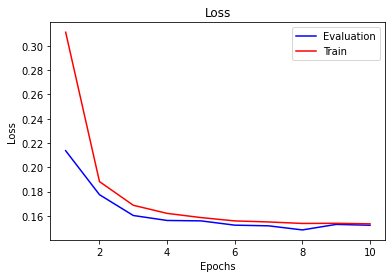

In [29]:
plt.plot(range(1, 11), pre_history['test_loss'],'b-', label='Evaluation')
plt.plot(range(1, 11), pre_history['train_loss'],'r-', label='Train')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title("Loss")
plt.show()

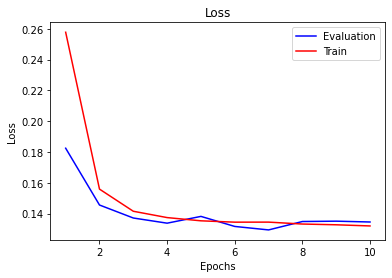

In [31]:
plt.plot(range(1, 11), cus_history['test_loss'],'b-', label='Evaluation')
plt.plot(range(1, 11), cus_history['train_loss'],'r-', label='Train')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title("Loss")
plt.show()

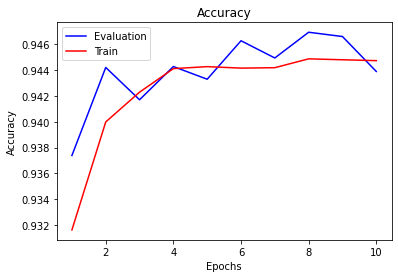

In [96]:
plt.plot(range(1, 11), pre_history['test_acc'],'b-', label='Evaluation')
plt.plot(range(1, 11), pre_history['train_acc'],'r-', label='Train')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title("Accuracy")
plt.show()

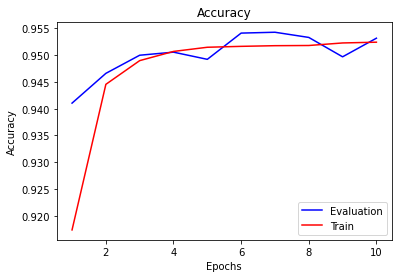

In [30]:
plt.plot(range(1, 11), cus_history['test_acc'],'b-', label='Evaluation')
plt.plot(range(1, 11), cus_history['train_acc'],'r-', label='Train')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title("Accuracy")
plt.show()